<a href="https://colab.research.google.com/github/jhoths/MamographyFYP/blob/main/Welcome_To_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import tensorflow as tf
import shutil as sh
import pandas as pd
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [5]:
current_working_directory = os.getcwd()

# print output to the console
print(current_working_directory)

/content


In [6]:
from google.colab import files
from os import environ

In [7]:
!pip install -q kaggle

In [8]:
# upload kaggle API key
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [9]:
# define kaggle config folder
! mkdir "./kaggle" && mv "./kaggle.json" "./kaggle/kaggle.json"
environ['KAGGLE_CONFIG_DIR'] = './kaggle'

# hide kaggle API key for other users
! chmod 600 ./kaggle/kaggle.json

In [10]:
# fetch kaggle dataset
!kaggle datasets download -d vishumaa/breasy-cancer-binary
!unzip "./*.zip" && rm *.zip [y]

 97% 457M/471M [00:18<00:00, 79.8MB/s]
100% 471M/471M [00:18<00:00, 27.3MB/s]
Archive:  ./breasy-cancer-binary.zip
  inflating: Breast_Cancer_Binary/benign/1-012.jpg  
  inflating: Breast_Cancer_Binary/benign/1-013.jpg  
  inflating: Breast_Cancer_Binary/benign/1-014.jpg  
  inflating: Breast_Cancer_Binary/benign/1-015.jpg  
  inflating: Breast_Cancer_Binary/benign/1-016.jpg  
  inflating: Breast_Cancer_Binary/benign/1-017.jpg  
  inflating: Breast_Cancer_Binary/benign/1-030.jpg  
  inflating: Breast_Cancer_Binary/benign/1-031.jpg  
  inflating: Breast_Cancer_Binary/benign/1-032.jpg  
  inflating: Breast_Cancer_Binary/benign/1-033.jpg  
  inflating: Breast_Cancer_Binary/benign/1-036.jpg  
  inflating: Breast_Cancer_Binary/benign/1-037.jpg  
  inflating: Breast_Cancer_Binary/benign/1-038.jpg  
  inflating: Breast_Cancer_Binary/benign/1-051.jpg  
  inflating: Breast_Cancer_Binary/benign/1-052.jpg  
  inflating: Breast_Cancer_Binary/benign/1-054.jpg  
  inflating: Breast_Cancer_Binary/ben

Found 231 images belonging to 2 classes.
Found 57 images belonging to 2 classes.
Epoch 1/20
8/8 [==============================] - 128s 15s/step - loss: 226.7516 - accuracy: 0.4589 - val_loss: 6.3747 - val_accuracy: 0.4561
Epoch 2/20
8/8 [==============================] - 129s 16s/step - loss: 34.8906 - accuracy: 0.5195 - val_loss: 2.7739 - val_accuracy: 0.5263
Epoch 3/20
8/8 [==============================] - 124s 15s/step - loss: 15.0942 - accuracy: 0.6190 - val_loss: 1.9983 - val_accuracy: 0.4912
Epoch 4/20
8/8 [==============================] - 112s 13s/step - loss: 6.2742 - accuracy: 0.7879 - val_loss: 2.2907 - val_accuracy: 0.5263
Epoch 5/20
8/8 [==============================] - 132s 16s/step - loss: 5.0211 - accuracy: 0.8095 - val_loss: 1.4004 - val_accuracy: 0.5965
Epoch 6/20
8/8 [==============================] - 121s 15s/step - loss: 6.9197 - accuracy: 0.7403 - val_loss: 4.1848 - val_accuracy: 0.5263
Epoch 7/20
8/8 [==============================] - 132s 16s/step - loss: 2.7

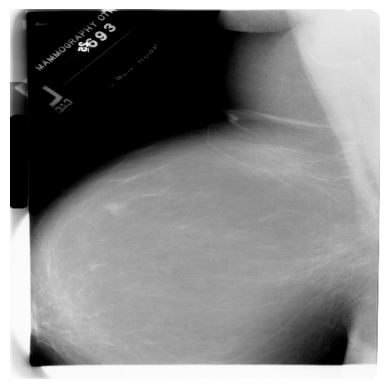

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

# Define data directory
data_dir = '/content/Breast_Cancer_Binary'

# Define image dimensions and batch size
image_height = 512
image_width = 512
batch_size = 32

# Data preprocessing
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Generate data batches
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')

# Define the model
model = Sequential([
    Conv2D(8, (3, 3), input_shape=(image_height, image_width, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    Conv2D(16, (3, 3)),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(32, (3, 3)),
    BatchNormalization(),
    Activation('relu'),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classifier
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with both training and validation data
history = model.fit(train_generator, epochs=20,
                    validation_data=val_generator, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print("Validation Accuracy:", accuracy)

model.save("my_model.keras")

# Test the model with a random image from the dataset
random_class = np.random.choice(os.listdir(data_dir))  # Choose a random class
random_image_path = os.path.join(data_dir, random_class)
random_image_filename = np.random.choice(os.listdir(random_image_path))  # Choose a random image
random_image_path = os.path.join(random_image_path, random_image_filename)

# Load and preprocess the random image
random_image = image.load_img(random_image_path, target_size=(image_height, image_width))
random_image_array = image.img_to_array(random_image)
random_image_array = np.expand_dims(random_image_array, axis=0)  # Expand dimensions to match model input shape
random_image_array /= 255.0  # Normalize

# Make predictions using the model
prediction = model.predict(random_image_array)

# Interpret the prediction result
if prediction <0.5:
  print("prediction:benign")
else:
    print("prediction : malignant")

# Display the random image
plt.imshow(random_image)
plt.axis("off")
plt.show()



In [12]:
print("randomly chosen image for testing",random_image_path)

randomly chosen image for testing /content/Breast_Cancer_Binary/benign/1-036.jpg


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping
# Define the model
model = Sequential([
    Conv2D(8, (3, 3), input_shape=(512,512, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    Conv2D(16, (3, 3)),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(32, (3, 3)),
    BatchNormalization(),
    Activation('relu'),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classifier
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 8)       224       
                                                                 
 batch_normalization (Batch  (None, 510, 510, 8)       32        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 510, 510, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 255, 255, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 16)      1168      
                                                                 
 batch_normalization_1 (Bat  (None, 253, 253, 16)      6